# Plot AOU versus O2 Saturation 
Compute delta AOU and delta O2 saturation for different regiobs (global, tropics, extratropics)

In [1]:
%matplotlib inline

from itertools import product

import numpy as np

import pandas as pd
import xarray as xr
import intake

import matplotlib.pyplot as plt
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [2]:
# Load collection
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 1115856 entries:
	> 17 activity_id(s)

	> 24 institution_id(s)

	> 48 source_id(s)

	> 82 experiment_id(s)

	> 163 member_id(s)

	> 35 table_id(s)

	> 1029 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 251 version(s)

	> 7799 time_range(s)

	> 1115856 path(s)

Look at the options in the collection.

In [3]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,day,pr,gn,NaN,v20190702,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,hfls,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,prsn,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,va,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,tas,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...


In [4]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id','table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 82,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', '1pctCO2-cdr',
                              'amip-future4K', 'amip-m4K', 'a4SST', 'aqua-p4K',
                              'piSST', 'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer', 'hist-nat',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-

Here we select the specific data we want.

In [5]:
#Choose experiments
experiments = ['historical', 'ssp585']

def get_models(table_id, variable_id):
    # all models
    models = set(uni_dict['source_id']['values'])

    for experiment_id in experiments:
        query = dict(experiment_id=experiment_id, variable_id=variable_id, 
                     table_id=table_id, grid_label='gn')  
        cat = col.search(**query)
        models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

    # ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
    return models - {'CESM2-WACCM', 'CESM2'}
    

models = {}    

# look for models with O2sat, the less common variable
models['Omon.o2sat'] = get_models('Omon', 'o2sat')
have_sat = models['Omon.o2sat']

# find models with O2sat that also have O2, the more common variable
models['Omon.o2'] = get_models('Omon', 'o2').intersection(have_sat)

models_all = list(models['Omon.o2'])
models

{'Omon.o2sat': {'UKESM1-0-LL'}, 'Omon.o2': {'UKESM1-0-LL'}}

Only UKESM1-0-LL has O2, O2sat. As a future direction we may want to calculate the o2sat using conservative temperature (bigthetao) and salinity (so). Next, we create a collection (cat) that contains a dataframe (df) that has only the data from the chosen model.

In [6]:
# Create dataframe
df = pd.DataFrame()

# Load in models list and pull out associated data
for key, val in models.items():
    model_list = list(val)
    table_id = key.split('.')[0]
    variable_id = key.split('.')[1]
    
    cat = col.search(experiment_id=experiments, table_id=table_id, 
                     variable_id=variable_id, 
                     source_id=model_list, grid_label='gn')
    df = pd.concat((df, cat.df))

cat.df = df.copy()
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
203448,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
203449,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
204815,CMIP,MOHC,UKESM1-0-LL,historical,r4i1p1f2,Omon,o2sat,gn,NaN,v20190708,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
204816,CMIP,MOHC,UKESM1-0-LL,historical,r4i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
205650,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
205651,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
206520,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
206521,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
208390,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
208391,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [7]:
# Here one can remove a query if needed.
bad_member = [dict(member_id='r4i1p1f2')
               ]

# copy the dataframe 
df = cat.df.copy()

# eliminate data
for elim in bad_member:
    condition = np.ones(len(df), dtype=bool)
    for key, val in elim.items():
        condition = condition & (df[key] == val)
    df = df.loc[~condition]

cat.df = df
df

#dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
#                                cdf_kwargs={'chunks': {'time': 48}, 'decode_times': False})
#dset_dict.keys()
#cat_fx = col.search(source_id=models_all, table_id='Ofx', grid_label='gn')
#cat_fx.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
203448,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
203449,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
205650,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
205651,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
206520,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
206521,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
208390,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
208391,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
1050580,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r3i1p1f2,Omon,o2sat,gn,NaN,v20190813,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
1050739,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r8i1p1f2,Omon,o2sat,gn,NaN,v20190906,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...


# To start smaller: 
Choose just one matching member id and source id

In [8]:
df_Omon_o2_sat = df[(cat.df.table_id == 'Omon') & (cat.df.source_id == 'UKESM1-0-LL') & (cat.df.member_id == 'r1i1p1f2') & (cat.df.variable_id == 'o2sat')]
df_Omon_o2 = df[(cat.df.table_id == 'Omon') & (cat.df.source_id == 'UKESM1-0-LL') & (cat.df.member_id == 'r1i1p1f2') & (cat.df.variable_id == 'o2')]

df = pd.concat((df_Omon_o2, df_Omon_o2_sat))

cat.df = df.copy()
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
206593,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
206594,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
1050843,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2,gn,NaN,v20190726,201501-204912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
1050844,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2,gn,NaN,v20190726,205001-209912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
1050845,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2,gn,NaN,v20190726,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
206520,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
206521,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
1050827,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2sat,gn,NaN,v20190726,201501-204912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
1050828,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2sat,gn,NaN,v20190726,205001-209912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
1050829,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2sat,gn,NaN,v20190726,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...


In [9]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {'time': 48}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


In [10]:
dset_dict.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn', 'ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Omon.gn'])

In [11]:
cat_fx = col.search(source_id='UKESM1-0-LL', table_id='Ofx', grid_label='gn')
cat_fx.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
209679,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,sftof,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209680,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,areacello,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209681,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,hfgeou,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209682,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,basin,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209683,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,deptho,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [12]:
# specify a list of queries to eliminate
corrupt_data = [dict(variable_id='areacello', source_id='IPSL-CM6A-LR',
                     experiment_id='historical', member_id='r2i1p1f1')
               ]

# copy the dataframe 
df = cat_fx.df.copy()

# eliminate data
for elim in corrupt_data:
    condition = np.ones(len(df), dtype=bool)
    for key, val in elim.items():
        condition = condition & (df[key] == val)
    df = df.loc[~condition]

df.drop_duplicates(subset=['source_id', 'variable_id'], inplace=True)
df['member_id'] = np.nan
cat_fx.df = df
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
209679,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,sftof,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209680,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,areacello,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209681,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,hfgeou,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209682,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,basin,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209683,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,deptho,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [13]:
fx_dsets = cat_fx.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                  cdf_kwargs={'chunks': {}, 'decode_times': False})
cat_fx.df


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
209679,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,sftof,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209680,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,areacello,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209681,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,hfgeou,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209682,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,basin,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
209683,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,deptho,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [14]:
fx_dsets.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn'])

In [15]:
for key, ds in fx_dsets.items():
    print(key)
    print(ds.data_vars)
    print()

CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn
Data variables:
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    type                |S3 ...
    sftof               (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    areacello           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    hfgeou              (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    basin               (j, i) float64 dask.array<chunksize=(330, 360), meta=np.ndarray>
    deptho              (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>



# Attempt to plot some parameters
Use the keys created for the catalog in order to pull out historical or RCP 8.5 scenarios.

In [16]:
historical = dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']
ssp585 = dset_dict['ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Omon.gn']

In [17]:
# Create initial conditions
time_0 = historical.sel(time = '1970-01-16')
time_1970_to_1999 = historical.sel(time = slice('1970-01-16', '1999-12-16'))
all_time = xr.concat([time_1970_to_1999,ssp585], dim='time')

In [18]:
# Calculate AOU at each time
all_time_aou = all_time.o2sat*1e3-all_time.o2

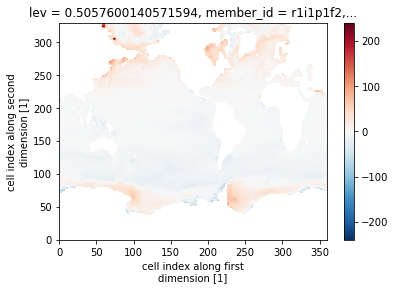

In [19]:
# Surface in Jan 1970
(all_time_aou.isel(member_id = 0, time = 0, lev = 0)*1e3).plot()

In [19]:
# Calculate delta AOU from time_0 values
delta_aou = all_time_aou - all_time_aou.isel(time = 0)
# Plot surface at time 0, should be 0
#delta_aou.isel(member_id = 0, time = 0, lev = 0).plot()

In [20]:
# Calculate delta O2 sat from time_0
delta_o2_sat = (all_time['o2sat'] - all_time['o2sat'].isel(time = 0))*1000
#delta_o2_sat.isel(member_id = 0, time = 100, lev = 0).plot()

In [21]:
# Calculate delta O2 since time_0
delta_o2 = all_time['o2'] - all_time['o2'].isel(time = 0)
#delta_o2.isel(member_id = 0, time = 100, lev = 0).plot()

# Calculate depth integrated oxygen to 1000 m

In [22]:
total_depth = fx_dsets['CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn']['deptho']
area = fx_dsets['CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn']['areacello']

#vol = area * total_depth
#vol.plot()

Check that time dim in lev_bnds is redundant.
```python
np.allclose(all_time.lev_bnds.isel(time=slice(0, 10))[0],
            all_time.lev_bnds.isel(time=slice(0, 10))[5])
>>> True
````


In [23]:
# lev_bnds is set up as two columns with top and bottom of cells.
#This one is at time = 0
lev_bnds = all_time['lev_bnds'].isel(time=0)
# this one is top 1000 m
lev_bnds_1000 = all_time['lev_bnds'].where(all_time['lev'] <= 1000, drop = True)

In [24]:
# Find the difference between the columns to find the depth steps for top 1000
dz = lev_bnds_1000.isel(bnds=1) - lev_bnds_1000.isel(bnds=0)
#dz

In [25]:
#squeeze takes out the 1-dimensional member_id (took that out here)
o2_example = all_time['o2']
o2_1000_int = (o2_example*dz).sum('lev')
o2_sat = all_time['o2sat']*1e3
o2_sat_int = (o2_sat*dz).sum('lev')
aou_int = (all_time_aou*dz).sum('lev')

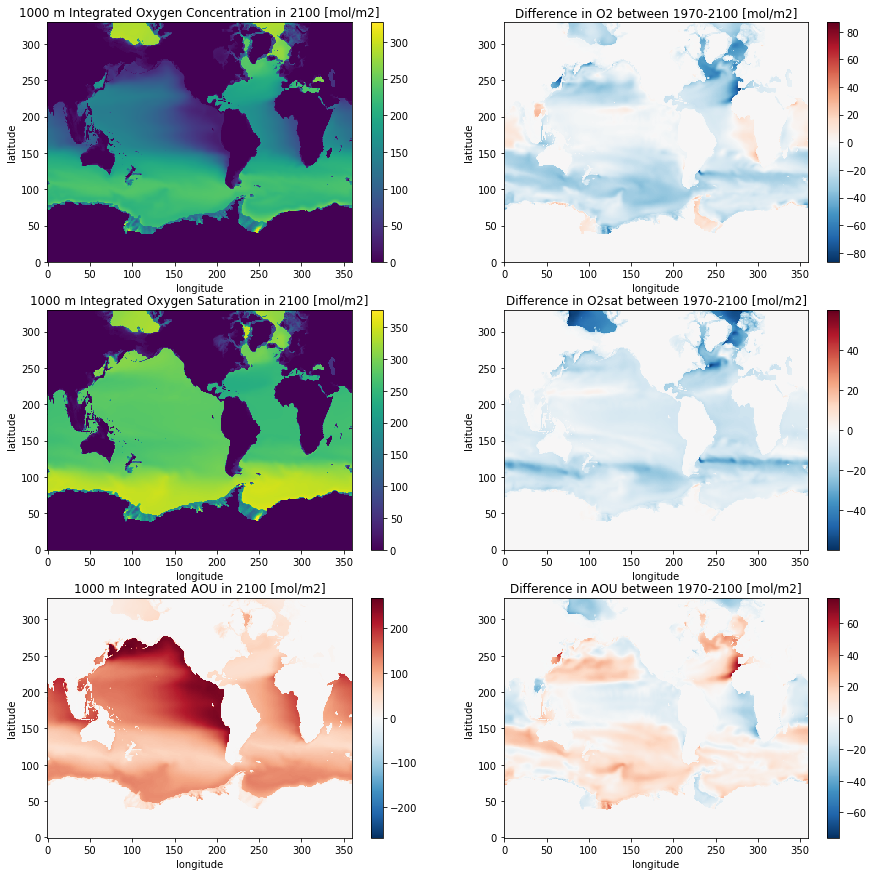

In [29]:
# Plots integrated O2 to 1000m (units: mol/m^2)
o2_1000_diff = o2_1000_int.isel(time=-1) - o2_1000_int.isel(time=0)
o2_sat_1000_diff = o2_sat_int.isel(time=-1) - o2_sat_int.isel(time=0)
aou_1000_diff = aou_int.isel(time=-1) - aou_int.isel(time=0)

fig, (axes) = plt.subplots(figsize=(15,15),nrows=3,ncols=2)
o2_1000_int.isel(time=-1).plot(ax=axes[0,0])
o2_1000_diff.plot(ax=axes[0,1])
o2_sat_int.isel(time=-1).plot(ax=axes[1,0])
o2_sat_1000_diff.plot(ax=axes[1,1])
aou_int.isel(time=-1).plot(ax=axes[2,0])
aou_1000_diff.plot(ax=axes[2,1])
     
axes[0,0].set_title("1000 m Integrated Oxygen Concentration in 2100 [mol/m2]")
axes[0,1].set_title("Difference in O2 between 1970-2100 [mol/m2]")
axes[1,0].set_title("1000 m Integrated Oxygen Saturation in 2100 [mol/m2]")
axes[1,1].set_title("Difference in O2sat between 1970-2100 [mol/m2]")
axes[2,0].set_title("1000 m Integrated AOU in 2100 [mol/m2]")
axes[2,1].set_title("Difference in AOU between 1970-2100 [mol/m2]")

for jj in range(0,2):
    for ii in range(0,3):
        axes[ii,jj].set_xlabel("longitude")
        axes[ii,jj].set_ylabel("latitude")

plt.show()
fig.savefig('six_plots_oxygen.png')

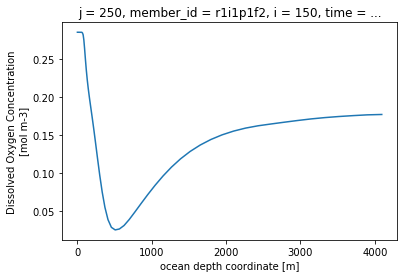

In [30]:
# Plot just a profile
all_time['o2'].isel(time=0,i=150,j=250).plot()

# Compute global average of depth-integrated AOU, O2, and O2sat per year

In [57]:
#global_mean_o2 = ((o2_1000_int*area).sum(['j','i'])/area.sum(['j','i'])).compute()
global_mean_o2sat = ((o2_sat_int*area).sum(['j','i'])/area.sum(['j','i'])).compute()
global_mean_aou = ((aou_int*area).sum(['j','i'])/area.sum(['j','i'])).compute()

In [58]:
# Then, find difference between each year and time_0 (1970)
# Calculate delta AOU from time_0 values
global_delta_aou = global_mean_aou - global_mean_aou.isel(time = 0)

In [59]:
# Calculate delta O2 from time_0 values
#global_delta_o2 = global_mean_o2 - global_mean_o2.isel(time = 0)
# Calculate delta O2sat from time_0 values
global_delta_o2_sat = global_mean_o2sat - global_mean_o2sat.isel(time = 0)

In [54]:
# Finally, plot delta AOU vs delta O2 sat!

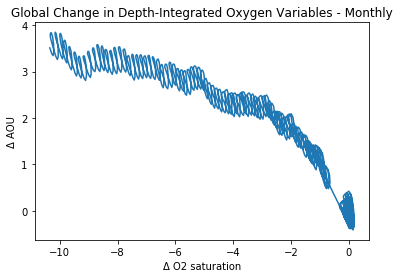

In [62]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.array(global_delta_o2_sat)[0],np.array(global_delta_aou)[0])

plt.xlabel("Δ O2 saturation")
plt.ylabel('Δ AOU')
plt.title('Global Change in Depth-Integrated Oxygen Variables - Monthly')

plt.show()

In [62]:
# Compute annual trend from monthly
annual_delta_o2_sat = global_delta_o2_sat.groupby('time.year').mean('time')
annual_delta_aou = global_delta_aou.groupby('time.year').mean('time')

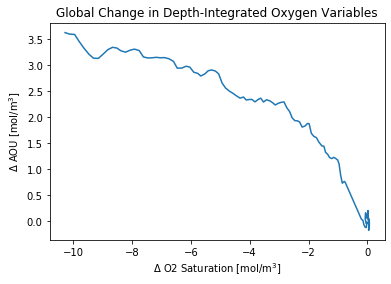

<Figure size 432x288 with 0 Axes>

In [63]:
fig = plt.plot(np.array(annual_delta_o2_sat)[0],np.array(annual_delta_aou)[0])
plt.xlabel("Δ O2 Saturation [mol/m$^3$]")
plt.ylabel('Δ AOU [mol/m$^3$]')
plt.title('Global Change in Depth-Integrated Oxygen Variables')

plt.show()

plt.savefig('aou_vs_o2sat.png')

Isolate tropical and extratropical (is it better to drop or use other = float('NaN')?)

In [31]:
tropics_o2_sat = o2_sat_int.where((o2_sat_int['j'] >= 141.5) & (o2_sat_int['j'] <= 188.5), drop = True)
tropics_aou = aou_int.where((o2_sat_int['j'] >= 141.5) & (o2_sat_int['j'] <= 188.5), drop = True)

extratropics_o2_sat = o2_sat_int.where((o2_sat_int['j'] < 141.5) | (o2_sat_int['j'] > 188.5), drop = True)
extratropics_aou = aou_int.where((o2_sat_int['j'] < 141.5) | (o2_sat_int['j'] > 188.5), drop = True)

In [34]:
tropics_o2_sat = o2_sat_int.where((o2_sat_int['j'] >= 141.5) & (o2_sat_int['j'] <= 188.5), other = float('NaN'))
tropics_aou = aou_int.where((o2_sat_int['j'] >= 141.5) & (o2_sat_int['j'] <= 188.5), other = float('NaN'))

Compute area means

In [35]:
# Compute areal means
tropics_mean_o2_sat = ((tropics_o2_sat*area).sum(['j','i'])/area.sum(['j','i'])).compute()

In [36]:
tropics_mean_aou = ((tropics_aou*area).sum(['j','i'])/area.sum(['j','i'])).compute()

In [27]:
extratropics_mean_aou = ((extratropics_aou*area).sum(['j','i'])/area.sum(['j','i'])).compute()
extratropics_mean_o2_sat = ((extratropics_o2_sat*area).sum(['j','i'])/area.sum(['j','i'])).compute()

In [ ]:
# Then, find difference between each year and time_0 (1970)
# Calculate delta AOU from time_0 values
tropics_delta_aou = tropics_mean_aou - tropics_mean_aou.isel(time = 0)
extratropics_delta_aou = extratropics_mean_aou - extratropics_mean_aou.isel(time = 0)

# Calculate delta O2sat from time_0 values
tropics_delta_o2_sat = tropics_mean_o2_sat - tropics_mean_o2_sat.isel(time = 0)
extratropics_delta_o2_sat = extratropics_mean_o2_sat - extratropics_mean_o2_sat.isel(time = 0)


In [37]:
tropics_delta_aou = tropics_mean_aou - tropics_mean_aou.isel(time = 0)
tropics_delta_o2_sat = tropics_mean_o2_sat - tropics_mean_o2_sat.isel(time = 0)

In [ ]:
# Calculate annuals
annual_tropics_delta_aou = tropics_delta_aou.groupby('time.year').mean('time')
annual_extratropics_delta_aou = extratropics_delta_aou.groupby('time.year').mean('time')
annual_extratropics_delta_o2_sat = extratropics_delta_o2_sat.groupby('time.year').mean('time')
annual_tropics_delta_o2_sat = tropics_delta_o2_sat.groupby('time.year').mean('time')

In [38]:
annual_tropics_delta_o2_sat = tropics_delta_o2_sat.groupby('time.year').mean('time')
annual_tropics_delta_aou = tropics_delta_aou.groupby('time.year').mean('time')

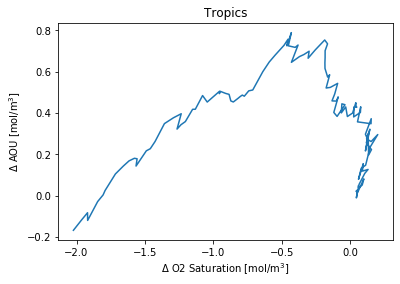

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure()
plt.plot(np.array(annual_tropics_delta_o2_sat)[0],np.array(annual_tropics_delta_aou)[0])
plt.xlabel("Δ O2 Saturation [mol/m$^3$]")
plt.ylabel('Δ AOU [mol/m$^3$]')
plt.title('Tropics')

plt.show()

plt.savefig('aou_vs_o2sat_tropics.png')

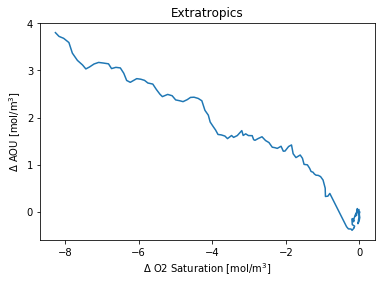

<Figure size 432x288 with 0 Axes>

In [33]:
plt.figure()
plt.plot(np.array(annual_extratropics_delta_o2_sat)[0],np.array(annual_extratropics_delta_aou)[0])
plt.xlabel("Δ O2 Saturation [mol/m$^3$]")
plt.ylabel('Δ AOU [mol/m$^3$]')
plt.title('Extratropics')

plt.show()

plt.savefig('aou_vs_o2sat_extratropics.png')

Text(0, 0.5, 'Δ AOU [mol/m$^3$]')

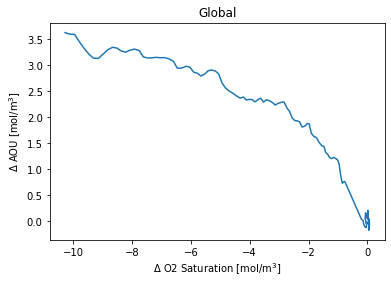

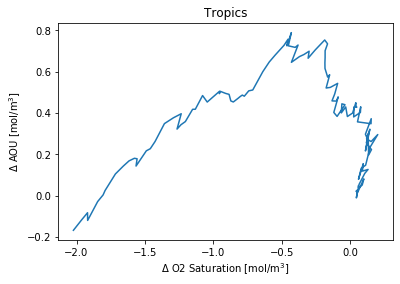

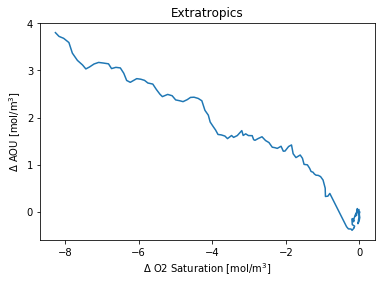

In [65]:
# Plots of AOU vs O2sat
plt.figure()
plt.plot(np.array(annual_delta_o2_sat)[0],np.array(annual_delta_aou)[0])
plt.xlabel("Δ O2 Saturation [mol/m$^3$]")
plt.ylabel('Δ AOU [mol/m$^3$]')
plt.title('Global')

plt.figure() 
plt.plot(np.array(annual_tropics_delta_o2_sat)[0],np.array(annual_tropics_delta_aou)[0])
plt.title('Tropics')
plt.xlabel("Δ O2 Saturation [mol/m$^3$]")
plt.ylabel('Δ AOU [mol/m$^3$]')

plt.figure()
fig = plt.plot(np.array(annual_extratropics_delta_o2_sat)[0],np.array(annual_extratropics_delta_aou)[0])
plt.title('Extratropics')
plt.xlabel("Δ O2 Saturation [mol/m$^3$]")
plt.ylabel('Δ AOU [mol/m$^3$]')